### 11. Dropout

- overfitting을 방지하기 위해, training과정에서 layer의 일부 node들을 무작위로 drop(비활성화) 하고, 
- 다수의 그 결과들을 종합한다. 
- Network Ensemble : dropout이 무작위로 이뤄짐 --> 서로다른 다수의 network들의 학습결과를 종합 --> 성능향상 
- 단 dropout은 training에만 적용된다. test단계에 적용되어서는 안된다. 

- dropout이 적용된 코드 
    1) layer 설정시 dropout할 Prob. 세팅 
    2) model 설정시 dropout 사용할 것임을 명시 
    3) 학습할때는 model.train, 검증할때는 model.eval() 

In [2]:
import torch 
import torchvision.datasets as dsets 
import torchvision.transforms as transforms 
import random 
import timeit
device = 'cpu'
#device = 'cuda' if torch.cuda.is_available() else 'cpu'

## parameters
training_epoch = 15 
batch_size = 100
learning_rate = 0.001

## dataset 
mnist_train = dsets.MNIST(root = 'MNIST_data/', 
                          train = True, 
                          transform = transforms.ToTensor(), 
                          download = True )

mnist_test = dsets.MNIST(root = 'MNIST_data/', 
                          train = False, 
                          transform = transforms.ToTensor(), 
                          download = True )

data_loader = torch.utils.data.DataLoader(dataset = mnist_train, 
                                          batch_size = batch_size, 
                                          shuffle = True, 
                                          drop_last = True )

## use 5 layers
linear1 = torch.nn.Linear(28*28, 512, bias = True)
linear2 = torch.nn.Linear(512, 512, bias = True)
linear3 = torch.nn.Linear(512, 512, bias = True)
linear4 = torch.nn.Linear(512, 512, bias = True)
linear5 = torch.nn.Linear(512, 10, bias = True)
relu = torch.nn.ReLU()
dropout = torch.nn.Dropout(p=0.3) ## set the prob. for dropout 

## 모형들의 weight를 xavier_uniform 분포로 초기화 
torch.nn.init.xavier_uniform_(linear1.weight)
torch.nn.init.xavier_uniform_(linear2.weight)
torch.nn.init.xavier_uniform_(linear3.weight)
torch.nn.init.xavier_uniform_(linear4.weight)
torch.nn.init.xavier_uniform_(linear5.weight)

## model, cost function, optimizer 
## softmax 대신 relu & SGD 대신 Adam 사용 
## model에서 dropout을 사용할 것임을 정의 
model = torch.nn.Sequential(linear1, relu, dropout,
                            linear2, relu, dropout,
                            linear3, relu, dropout).to(device)

criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
#optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

total_batch = len(data_loader)
model.train()  ## model is train mode (dropout=True)

start_time = timeit.default_timer()  ## start time check 

for epoch in range(training_epoch) : 
    avg_cost = 0 
    for X, Y in data_loader : 
        X = X.view(-1, 28*28).to(device)
        Y = Y.to(device)
        hypothesis = model(X)
        cost = criterion(hypothesis, Y)
        
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        
        avg_cost += cost / total_batch
        
    print('epoch:', epoch+1, 'cost=', avg_cost)
    
end_time = timeit.default_timer()  ## end time check
print('Running time :', end_time - start_time)

epoch: 1 cost= tensor(2.2862, grad_fn=<AddBackward0>)
epoch: 2 cost= tensor(2.0607, grad_fn=<AddBackward0>)
epoch: 3 cost= tensor(2.0084, grad_fn=<AddBackward0>)
epoch: 4 cost= tensor(1.9764, grad_fn=<AddBackward0>)
epoch: 5 cost= tensor(1.9443, grad_fn=<AddBackward0>)
epoch: 6 cost= tensor(1.9353, grad_fn=<AddBackward0>)
epoch: 7 cost= tensor(1.9405, grad_fn=<AddBackward0>)
epoch: 8 cost= tensor(1.9559, grad_fn=<AddBackward0>)
epoch: 9 cost= tensor(1.9173, grad_fn=<AddBackward0>)
epoch: 10 cost= tensor(1.9301, grad_fn=<AddBackward0>)
epoch: 11 cost= tensor(1.9367, grad_fn=<AddBackward0>)
epoch: 12 cost= tensor(1.9281, grad_fn=<AddBackward0>)
epoch: 13 cost= tensor(1.9184, grad_fn=<AddBackward0>)
epoch: 14 cost= tensor(1.8884, grad_fn=<AddBackward0>)
epoch: 15 cost= tensor(1.9333, grad_fn=<AddBackward0>)
Running time : 304.1500180000003


c:\python\lib\site-packages\torchvision\datasets\mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
c:\python\lib\site-packages\torchvision\datasets\mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


Accuracy: 0.982200026512146
Label:  3
Prediction:  3


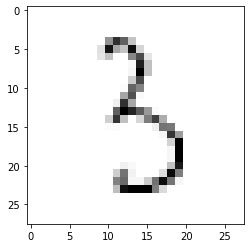

In [3]:
# Test the model using test sets
import matplotlib.pyplot as plt

with torch.no_grad():
    model.eval()  ## No dropout!! 
    
    X_test = mnist_test.test_data.view(-1, 28 * 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    prediction = model(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

    # Get one and predict
    r = random.randint(0, len(mnist_test) - 1)
    X_single_data = mnist_test.test_data[r:r + 1].view(-1, 28 * 28).float().to(device)
    Y_single_data = mnist_test.test_labels[r:r + 1].to(device)

    single_prediction = model(X_single_data)
    print('Label: ', Y_single_data.item())
    print('Prediction: ', torch.argmax(single_prediction, 1).item())
    
    plt.imshow(mnist_test.test_data[r:r + 1].view(28, 28), cmap='Greys', interpolation='nearest')
    plt.show()